In [1]:
import pandas as pd
from tqdm import tqdm
import re
from collections import Counter
import networkx as nx

df = pd.read_csv("output/reddit_sentence_level_valence_arousal_severity.csv")

# Also load subreddit data
posts = pd.read_csv("output/pre_processed_data_full_sentence.csv") 


In [2]:
df

processed_text  avg_valence  \
0     life quite expected hello dark place last 2 ye...    -0.065946   
1     cannot things right literally nothing ever go ...    -0.605782   
2     anything life becoming depressing listen serio...    -0.541485   
3     feeling really alone need someone kind talk ca...     0.303884   
4     numb cw vent kind new still figuring functions...    -0.411917   
...                                                 ...          ...   
9985  unsure pursue diagnosis somebody know suggeste...    -0.194371   
9986  addictions various forms. mother stepfather be...    -0.578336   
9987  date cptsd wondering people cptsd deal dating....    -0.122083   
9988  fathers day tough anyone else tw emotional abu...    -0.185398   
9989  emotional truck get back feel like hit emotion...    -0.025779   

      avg_arousal  raw_severity  \
0        0.625992      0.054458   
1        0.737223      0.470073   
2        0.699213      0.400956   
3        0.630236     -0.200598   
4        0.671656      0.304310   
...           ...           ...   
9985     0.622397      0.134976   
9986     0.700138      0.424829   
9987     0.593841      0.075895   
9988     0.632906      0.138654   
9989     0.559615      0.014426   

                                       sentence_details  severity  
0     [{'sentence': 'life quite expected hello dark ...  0.503754  
1     [{'sentence': 'cannot things right literally n...  0.788120  
2     [{'sentence': 'anything life becoming depressi...  0.740829  
3     [{'sentence': 'feeling really alone need someo...  0.329244  
4     [{'sentence': 'numb cw vent kind new still fig...  0.674704  
...                                                 ...       ...  
9985  [{'sentence': 'unsure pursue diagnosis somebod...  0.558845  
9986  [{'sentence': 'addictions various forms', 'Pos...  0.757164  
9987  [{'sentence': 'date cptsd wondering people cpt...  0.518422  
9988  [{'sentence': 'fathers day tough anyone else t...  0.561362  
9989  [{'sentence': 'emotional truck get back feel l...  0.476365  

[9990 rows x 6 columns]

In [3]:
posts

type  post_id  comment_id                author          created_utc  \
0     post  1lf4g6e         NaN  Medical-Teaching-405  2025-06-19T07:11:08   
1     post  1lf4emr         NaN      Ok-Broccoli-1906  2025-06-19T07:08:25   
2     post  1lf4bx2         NaN        AsideSuper7951  2025-06-19T07:03:32   
3     post  1lf4bva         NaN  Glass_Marionberry_33  2025-06-19T07:03:27   
4     post  1lf48hv         NaN              Bannatan  2025-06-19T06:57:44   
...    ...      ...         ...                   ...                  ...   
9985  post  1lc1qu1         NaN        limeandlemons-  2025-06-15T14:33:32   
9986  post  1lc1pxe         NaN            Alexxx3001  2025-06-15T14:32:23   
9987  post  1lc1kfa         NaN     LankyComputer8192  2025-06-15T14:25:26   
9988  post  1lc1j7t         NaN          Joanna_Flock  2025-06-15T14:23:57   
9989  post  1lc1iek         NaN         -Distraction-  2025-06-15T14:22:55   

      score                                             title  \
0         1                               life quite expected   
1         1                               cannot things right   
2         1                 anything life becoming depressing   
3         1  feeling really alone need someone kind talk call   
4         1                                      numb cw vent   
...     ...                                               ...   
9985      1                           unsure pursue diagnosis   
9986      1                         addictions various forms.   
9987      4                                        date cptsd   
9988      6                     fathers day tough anyone else   
9989      1                          emotional truck get back   

                                                   text   subreddit  \
0     hello dark place last 2 years reached lowest p...  depression   
1     literally nothing ever go right anymore makes ...  depression   
2     listen seriously asking happiness child life s...  depression   
3     hi really hard time right need someone kind ta...  depression   
4     kind new still figuring functions forgive xd s...  depression   
...                                                 ...         ...   
9985  somebody know suggested might cptsd. based rea...       CPTSD   
9986  mother stepfather became militant jehovahs wit...       CPTSD   
9987  wondering people cptsd deal dating. case famil...       CPTSD   
9988  tw emotional abuse mental abuse struggling lot...       CPTSD   
9989  feel like hit emotional truck three weeks know...       CPTSD   

                                flair  \
0                                 NaN   
1                                 NaN   
2                                 NaN   
3                                 NaN   
4                                 NaN   
...                               ...   
9985                         Question   
9986       Trigger Warning: Addiction   
9987                         Question   
9988  Trigger Warning: Physical Abuse   
9989                         Question   

                                                    url  parent_id  \
0     https://www.reddit.com/r/depression/comments/1...        NaN   
1     https://www.reddit.com/r/depression/comments/1...        NaN   
2     https://www.reddit.com/r/depression/comments/1...        NaN   
3     https://www.reddit.com/r/depression/comments/1...        NaN   
4     https://www.reddit.com/r/depression/comments/1...        NaN   
...                                                 ...        ...   
9985  https://www.reddit.com/r/CPTSD/comments/1lc1qu...        NaN   
9986  https://www.reddit.com/r/CPTSD/comments/1lc1px...        NaN   
9987  https://www.reddit.com/r/CPTSD/comments/1lc1kf...        NaN   
9988  https://www.reddit.com/r/CPTSD/comments/1lc1j7...        NaN   
9989  https://www.reddit.com/r/CPTSD/comments/1lc1ie...        NaN   

      upvote_ratio  upvotes  downvotes  \
0             1.00        1          0   
1             1.0

In [5]:
import nltk
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

def get_clean_words(text):
    text = str(text).lower()
    words = re.findall(r'\b[a-z]{3,}\b', text)
    return [w for w in words if w not in stop]

# Add processed_text if missing
posts['processed_text'] = posts['processed_text'].astype(str)

subreddit_topics = {}

for sub, group in tqdm(posts.groupby("subreddit"), desc="Extracting subreddit topics"):
    words = []

    for text in group['processed_text']:
        words.extend(get_clean_words(text))

    top_words = Counter(words).most_common(20)   # top 20 topic words
    subreddit_topics[sub] = [w for w, _ in top_words]

# Save for reference
pd.DataFrame([
    {"subreddit": sub, "topics": topics}
    for sub, topics in subreddit_topics.items()
]).to_csv("output/subreddit_topics.csv", index=False)


Extracting subreddit topics: 100%|██████████| 18/18 [00:01<00:00,  9.62it/s]


In [7]:
df1 = pd.read_csv("output/subreddit_topics.csv")
df1

subreddit                                             topics
0                 ADHD  ['like', 'adhd', 'feel', 'get', 'time', 'know'...
1              Anxiety  ['anxiety', 'like', 'feel', 'know', 'get', 're...
2                  BPD  ['like', 'feel', 'know', 'want', 'bpd', 'get',...
3                CPTSD  ['like', 'feel', 'would', 'know', 'even', 'peo...
4   DecidingToBeBetter  ['like', 'feel', 'want', 'know', 'life', 'time...
5            KindVoice  ['like', 'feel', 'someone', 'would', 'know', '...
6                  OCD  ['ocd', 'like', 'feel', 'know', 'thoughts', 'w...
7         SuicideWatch  ['want', 'like', 'feel', 'know', 'life', 'cann...
8       TrueOffMyChest  ['like', 'would', 'know', 'feel', 'time', 'eve...
9           confession  ['like', 'know', 'would', 'time', 'one', 'feel...
10          depression  ['like', 'feel', 'want', 'life', 'know', 'even...
11     depression_help  ['like', 'feel', 'know', 'want', 'life', 'get'...
12              lonely  ['like', 'feel', 'people', 'friends', 'know', ...
13        mentalhealth  ['like', 'feel', 'know', 'even', 'want', 'get'...
14          offmychest  ['like', 'feel', 'know', 'want', 'would', 'eve...
15                ptsd  ['like', 'feel', 'know', 'ptsd', 'would', 'get...
16       socialanxiety  ['like', 'people', 'feel', 'anxiety', 'know', ...
17             therapy  ['like', 'feel', 'know', 'want', 'therapy', 'w...

In [10]:
def find_topic_words(sentence, subreddit):
    sent = str(sentence).lower()
    topics = subreddit_topics.get(subreddit, [])
    return [w for w in topics if w in sent]

df["topic_words"] = posts.apply(
    lambda x: find_topic_words(x["processed_text"], x["subreddit"]), axis=1
)

In [12]:
def detect_emotion(valence, arousal, severity):
    if severity > 0.6 or (valence < -0.3 and arousal > 0.6):
        return "stress"
    elif valence < -0.4:
        return "sad"
    elif arousal > 0.7:
        return "anxious"
    elif valence > 0.3:
        return "positive"
    else:
        return "neutral"

df["emotion"] = df.apply(
    lambda x: detect_emotion(x["avg_valence"], x["avg_arousal"], x["severity"]),
    axis=1
)


In [13]:
connections = {}

for _, row in df.iterrows():
    emo = row["emotion"]
    topics = row["topic_words"]
    
    for t in topics:
        key = (emo, t)
        connections[key] = connections.get(key, 0) + 1


In [14]:
con_df = pd.DataFrame([
    {"emotion": emo, "topic": topic, "count": count}
    for (emo, topic), count in connections.items()
])


In [22]:
con_df["percentage"] = con_df["count"] / con_df.groupby("emotion")["count"].transform("sum") * 100

In [23]:
con_df.to_csv("output/emotion_topic_links_auto.csv", index=False)
print("Saved emotion_topic_links_auto.csv")


Saved emotion_topic_links_auto.csv


In [24]:
G = nx.Graph()

for _, r in con_df.iterrows():
    emo = r["emotion"]
    topic = r["topic"]
    weight = r["percentage"]

    G.add_edge(emo, topic, weight=weight)

nx.write_gexf(G, "emotion_topic_network_auto.gexf")
print("Saved emotion_topic_network_auto.gexf")


Saved emotion_topic_network_auto.gexf


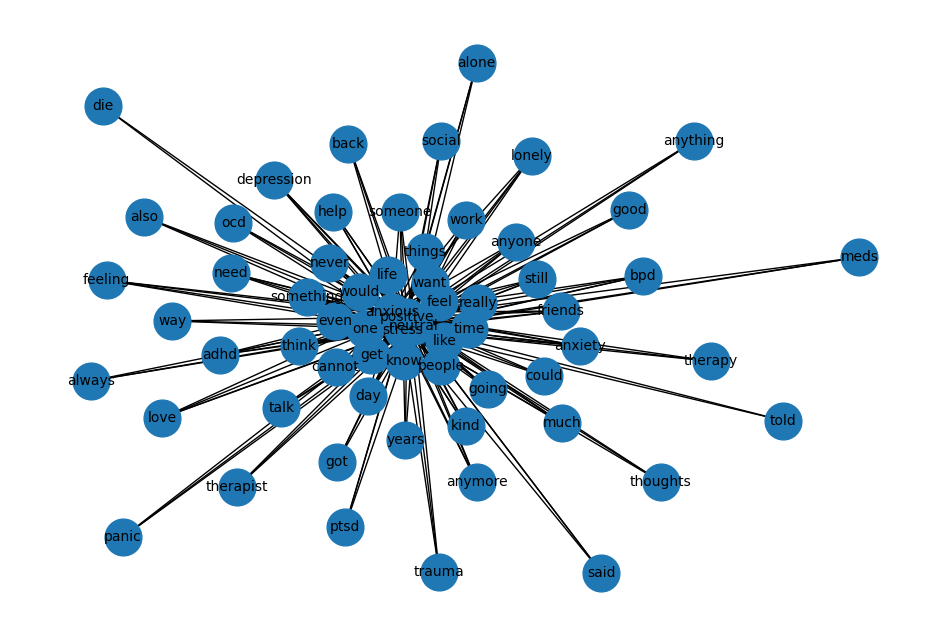

In [25]:
import matplotlib.pyplot as plt
import networkx as nx

# Create the graph again (assuming con_df already exists in the environment)
G = nx.Graph()
for _, r in con_df.iterrows():
    emo = r["emotion"]
    topic = r["topic"]
    weight = r["percentage"]
    G.add_edge(emo, topic, weight=weight)

# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.5, iterations=100)

# Draw nodes and edges (no colors specified)
nx.draw_networkx_nodes(G, pos, node_size=700)
nx.draw_networkx_edges(G, pos, width=1)
nx.draw_networkx_labels(G, pos, font_size=10)

plt.axis("off")
plt.show()

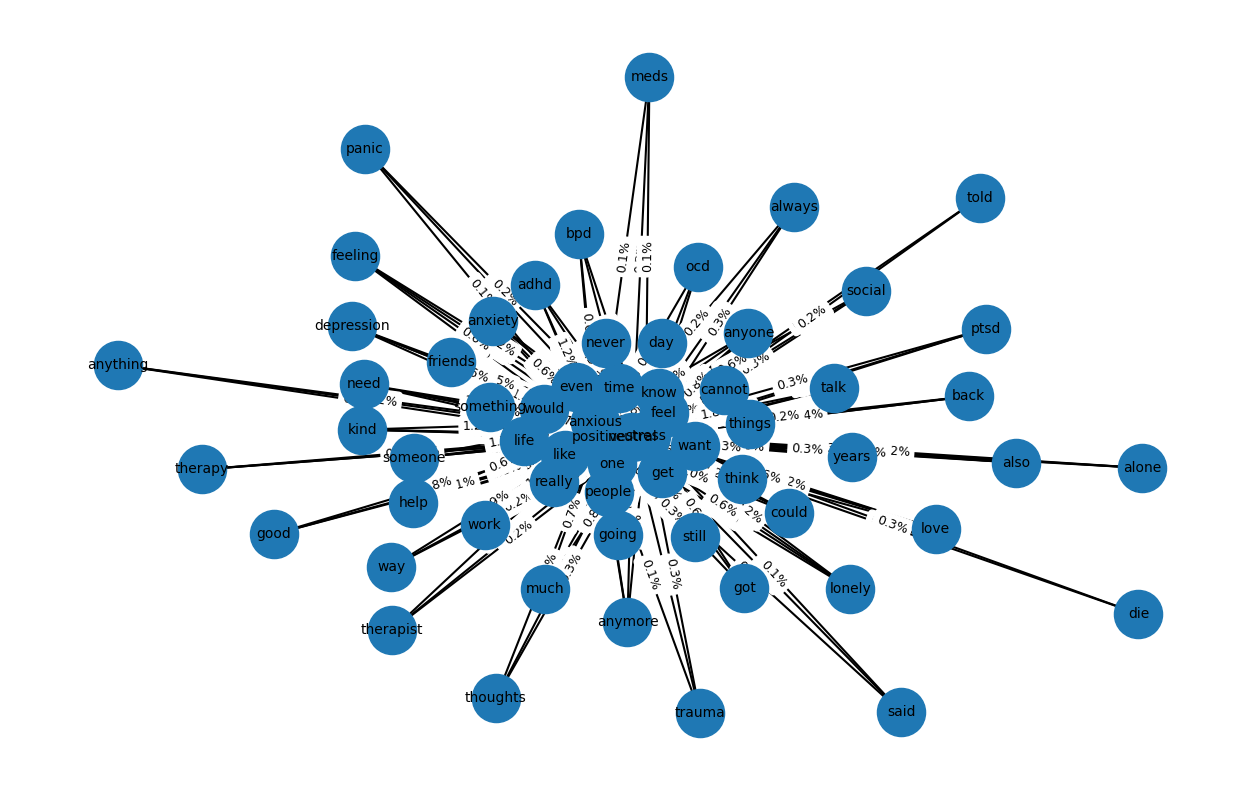

In [26]:
import matplotlib.pyplot as plt
import networkx as nx

# Make sure con_df is loaded before this:
# con_df = pd.read_csv("your_file.csv")

G = nx.Graph()

# Build graph
for _, r in con_df.iterrows():
    emo = r["emotion"]
    topic = r["topic"]
    weight = r["percentage"]  # edge weight
    G.add_edge(emo, topic, weight=weight)

# Wider layout: increase "k"
plt.figure(figsize=(16, 10))

pos = nx.spring_layout(G, k=1.2, iterations=200)  
# k ↑ → nodes spread wider

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=1200)

# Draw edges
nx.draw_networkx_edges(G, pos, width=1.5)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=10)

# Edge labels (percentage)
edge_labels = nx.get_edge_attributes(G, "weight")
edge_labels = {k: f"{v:.1f}%" for k, v in edge_labels.items()}

nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)

plt.axis("off")
plt.show()


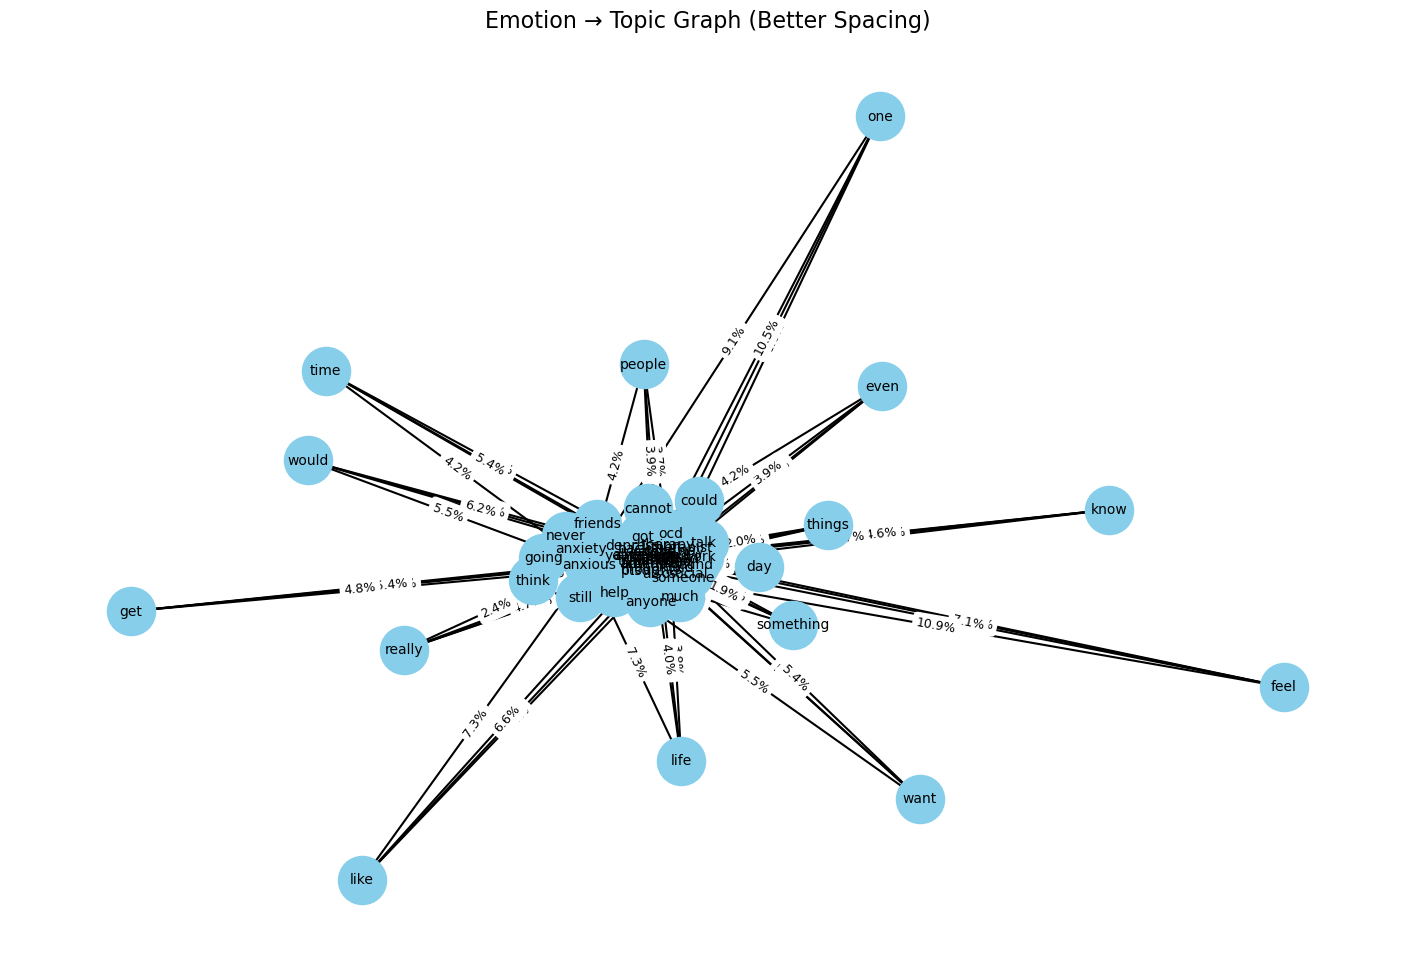

In [30]:
###### import matplotlib.pyplot as plt
import networkx as nx

# Recreate the graph
G = nx.Graph()
for _, r in con_df.iterrows():
    emo = r["emotion"]
    topic = r["topic"]
    weight = r["percentage"]
    G.add_edge(emo, topic, weight=weight)

# Use Kamada-Kawai layout (less overlapping)
pos = nx.kamada_kawai_layout(G, scale=2)  # scale ↑ spreads nodes

plt.figure(figsize=(18, 12))

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=1200, node_color="skyblue")

# Draw edges
nx.draw_networkx_edges(G, pos, width=1.5)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=10)

# Edge labels (percentage)
edge_labels = nx.get_edge_attributes(G, "weight")
edge_labels = {k: f"{v:.1f}%" for k, v in edge_labels.items()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)

plt.title("Emotion → Topic Graph (Better Spacing)", fontsize=16)
plt.axis("off")
plt.show()


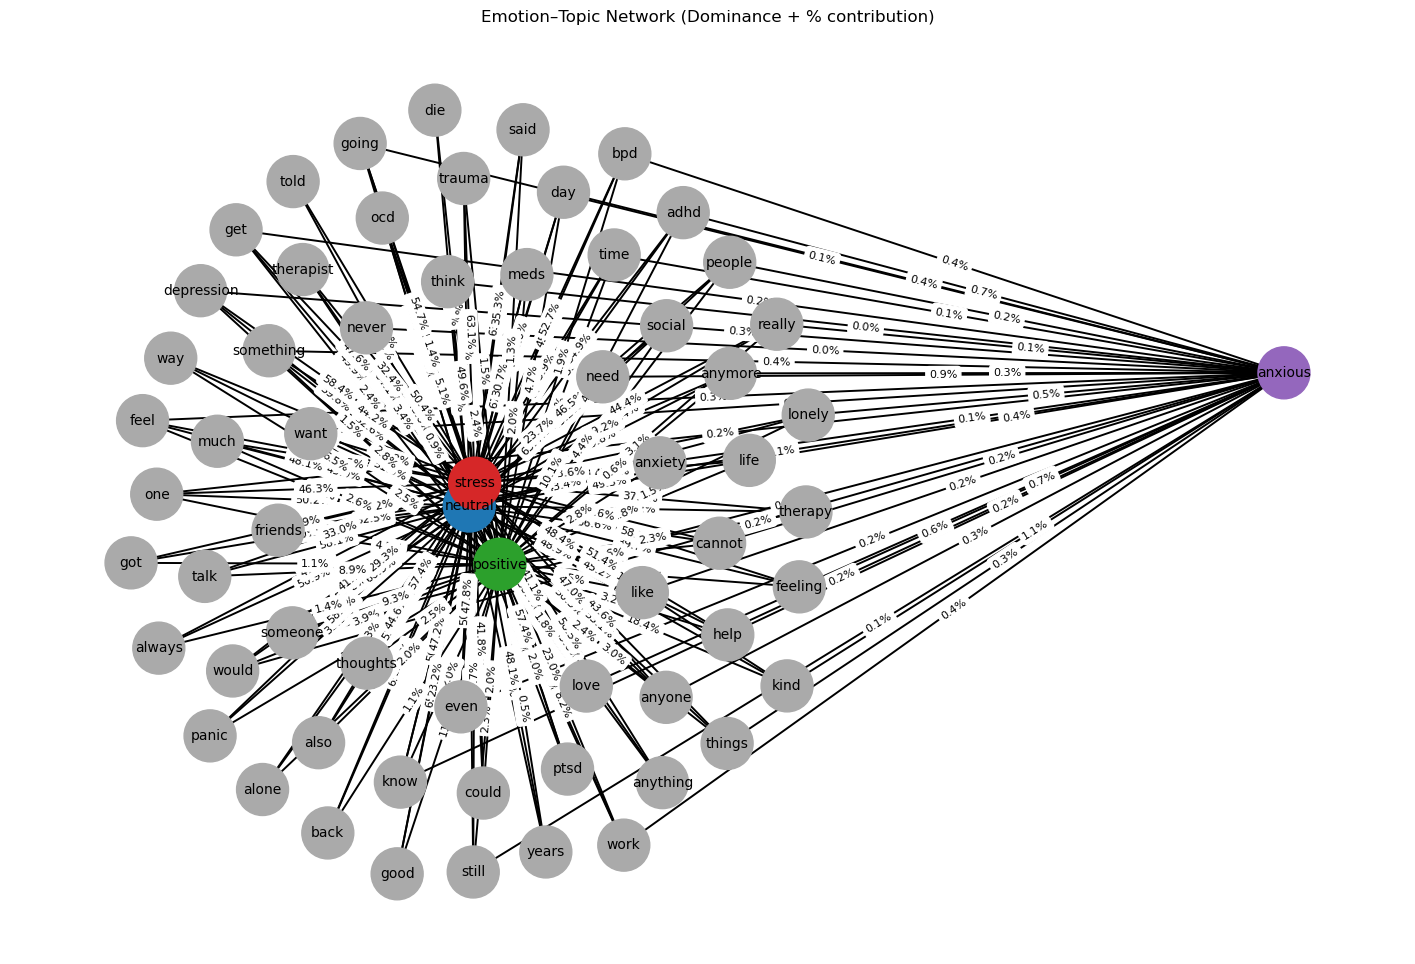

In [37]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# --------------------------------------------------
# 1. Load your dataset
# --------------------------------------------------
df = pd.read_csv("emotion_topic_links_auto.csv")   # use your file name

# Ensure correct types
df["topic"] = df["topic"].astype(str)
df["emotion"] = df["emotion"].astype(str)

# --------------------------------------------------
# 2. Compute total counts per topic
# --------------------------------------------------
topic_totals = df.groupby("topic")["count"].sum().reset_index()
topic_totals.rename(columns={"count": "total_count"}, inplace=True)

df = df.merge(topic_totals, on="topic")

# --------------------------------------------------
# 3. Compute % weight of each emotion in each topic
# --------------------------------------------------
df["percentage"] = (df["count"] / df["total_count"]) * 100

# --------------------------------------------------
# 4. Determine dominant emotion for each topic
# --------------------------------------------------
dominant = (
    df.sort_values(["topic", "count"], ascending=[True, False])
      .drop_duplicates("topic")
      [["topic", "emotion", "count"]]
      .rename(columns={"emotion": "dominant_emotion", "count": "max_count"})
)

df = df.merge(dominant, on="topic")

# --------------------------------------------------
# 5. Build the network graph
# --------------------------------------------------
G = nx.Graph()

for _, row in df.iterrows():
    emo = row["emotion"]
    topic = row["topic"]
    pct = row["percentage"]

    # Add edge with percentage
    G.add_edge(emo, topic, weight=pct)

# --------------------------------------------------
# 6. Draw the graph (clean, non-overlapping)
# --------------------------------------------------

plt.figure(figsize=(18, 12))

# Prevent overlap using a bigger k
pos = nx.spring_layout(G, k=2.0, iterations=300)

# Color emotions differently
emotion_colors = {
    "neutral": "#1f77b4",
    "stress": "#d62728",
    "positive": "#2ca02c",
    "anxious": "#9467bd"
}

node_colors = []
for n in G.nodes():
    if n in emotion_colors:
        node_colors.append(emotion_colors[n])
    else:
        node_colors.append("#aaaaaa")   # topic nodes = gray

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=1400, node_color=node_colors)

# Draw edges
nx.draw_networkx_edges(G, pos, width=1.4)

# Node labels
nx.draw_networkx_labels(G, pos, font_size=10)

# Edge labels with % formatted
edge_labels = nx.get_edge_attributes(G, "weight")
edge_labels = {k: f"{v:.1f}%" for k, v in edge_labels.items()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

plt.title("Emotion–Topic Network (Dominance + % contribution)")
plt.axis("off")
plt.show()


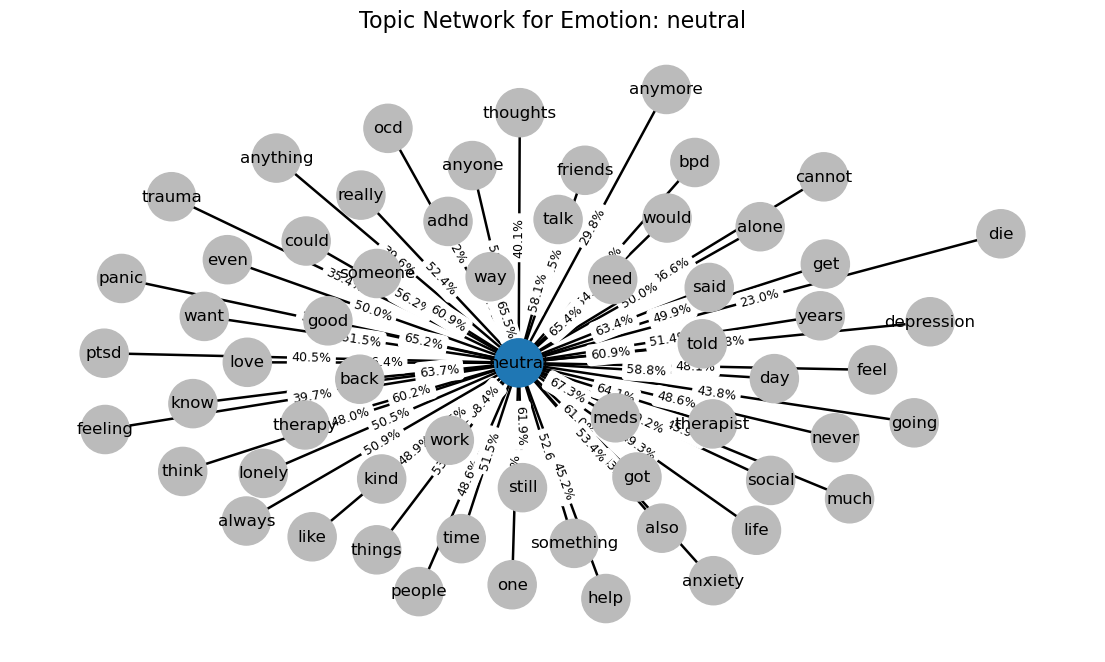

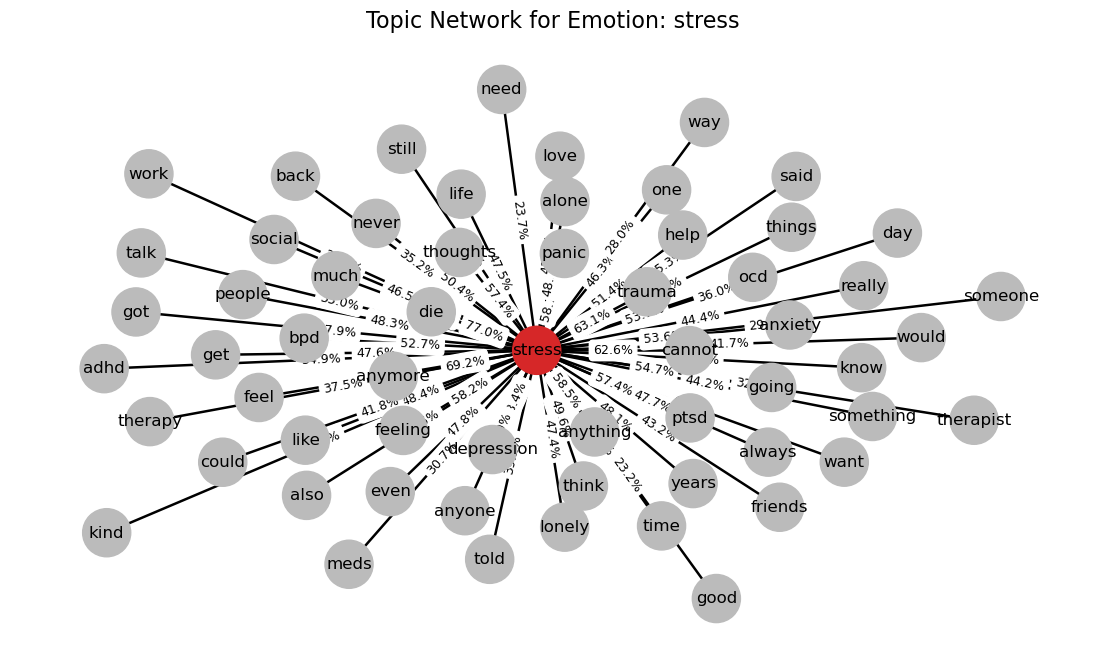

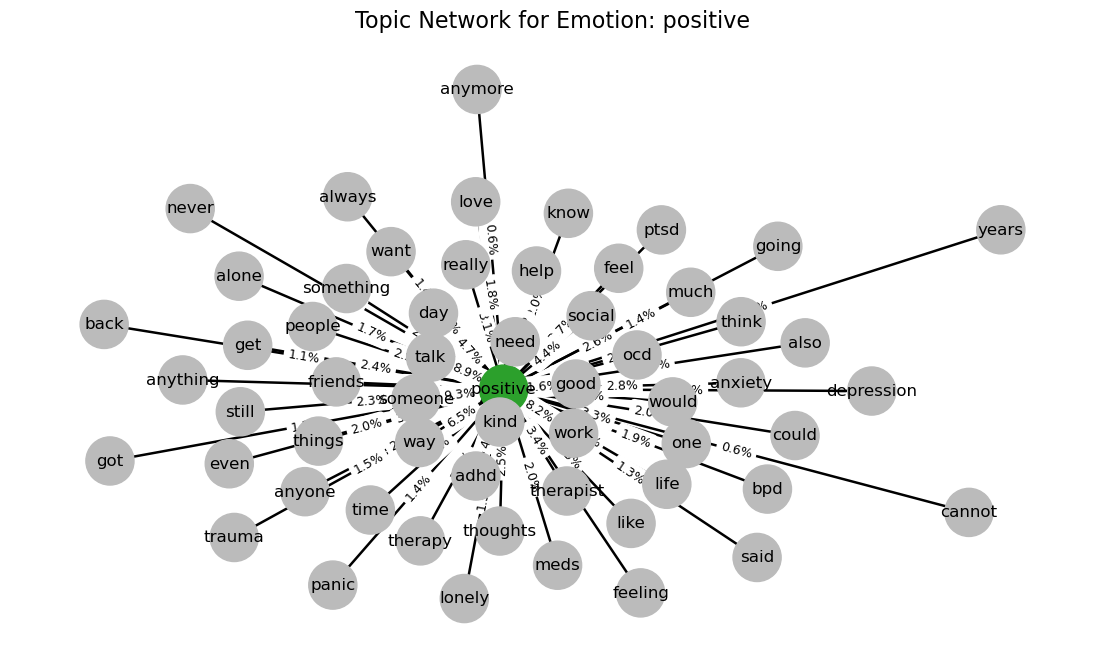

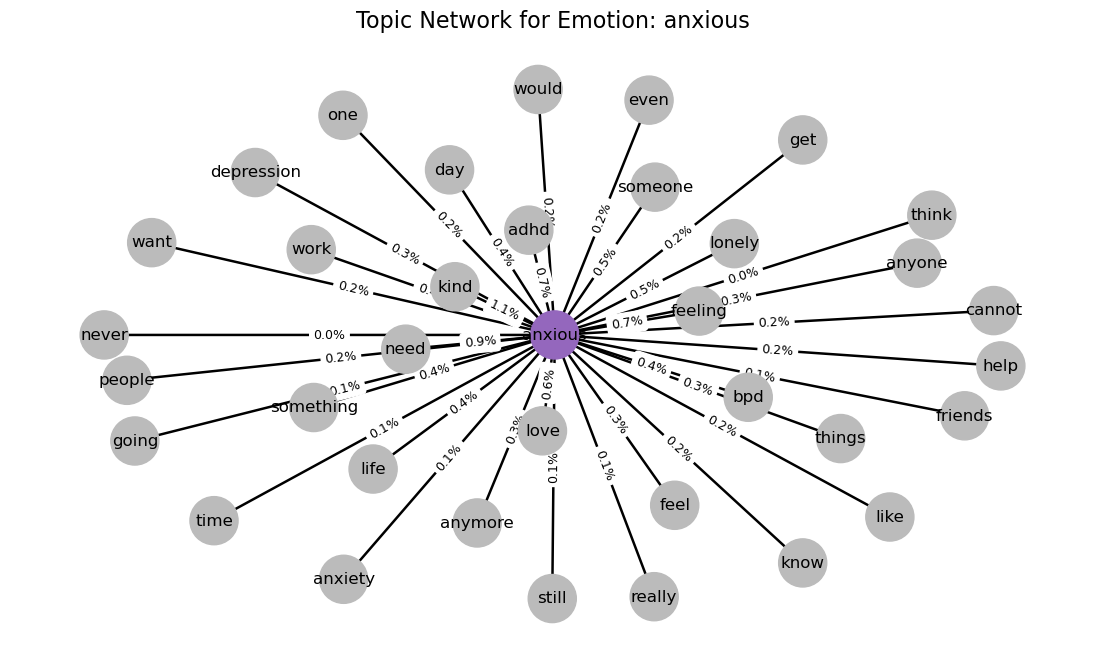

In [38]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# -----------------------------
# 1. LOAD YOUR DATA
# -----------------------------
df = pd.read_csv("emotion_topic_links_auto.csv")   # change filename

# ensure correct types
df["emotion"] = df["emotion"].astype(str)
df["topic"] = df["topic"].astype(str)

# -----------------------------
# 2. TOTAL COUNT PER TOPIC
# -----------------------------
topic_total = df.groupby("topic")["count"].sum().reset_index()
topic_total.columns = ["topic", "topic_total"]

df = df.merge(topic_total, on="topic")

# -----------------------------
# 3. PERCENTAGE per emotion-topic
# -----------------------------
df["percentage"] = (df["count"] / df["topic_total"]) * 100


# -----------------------------
# 4. GRAPH COLORS
# -----------------------------
emotion_colors = {
    "neutral": "#1f77b4",
    "stress": "#d62728",
    "positive": "#2ca02c",
    "anxious": "#9467bd"
}

# -----------------------------
# 5. FUNCTION TO DRAW PER-EMOTION GRAPH
# -----------------------------
def draw_emotion_graph(df, emotion):
    subset = df[df["emotion"] == emotion]

    if subset.empty:
        print(f"No data for emotion: {emotion}")
        return

    G = nx.Graph()

    # add edges from emotion → topic with percentage weight
    for _, row in subset.iterrows():
        G.add_edge(emotion, row["topic"], weight=row["percentage"])

    plt.figure(figsize=(14, 8))

    # wide spacing
    pos = nx.spring_layout(G, k=2.0, iterations=200)

    # node colors
    node_colors = []
    for node in G.nodes():
        if node == emotion:
            node_colors.append(emotion_colors[emotion])
        else:
            node_colors.append("#bbbbbb")  # topic nodes grey

    # draw graph
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=1200)
    nx.draw_networkx_edges(G, pos, width=1.8)
    nx.draw_networkx_labels(G, pos)

    # edge labels (%)
    edge_labels = nx.get_edge_attributes(G, "weight")
    edge_labels = {k: f"{v:.1f}%" for k, v in edge_labels.items()}

    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)

    plt.title(f"Topic Network for Emotion: {emotion}", fontsize=16)
    plt.axis("off")
    plt.show()


# -----------------------------
# 6. DRAW ALL EMOTION GRAPHS
# -----------------------------
for emotion in ["neutral", "stress", "positive", "anxious"]:
    draw_emotion_graph(df, emotion)


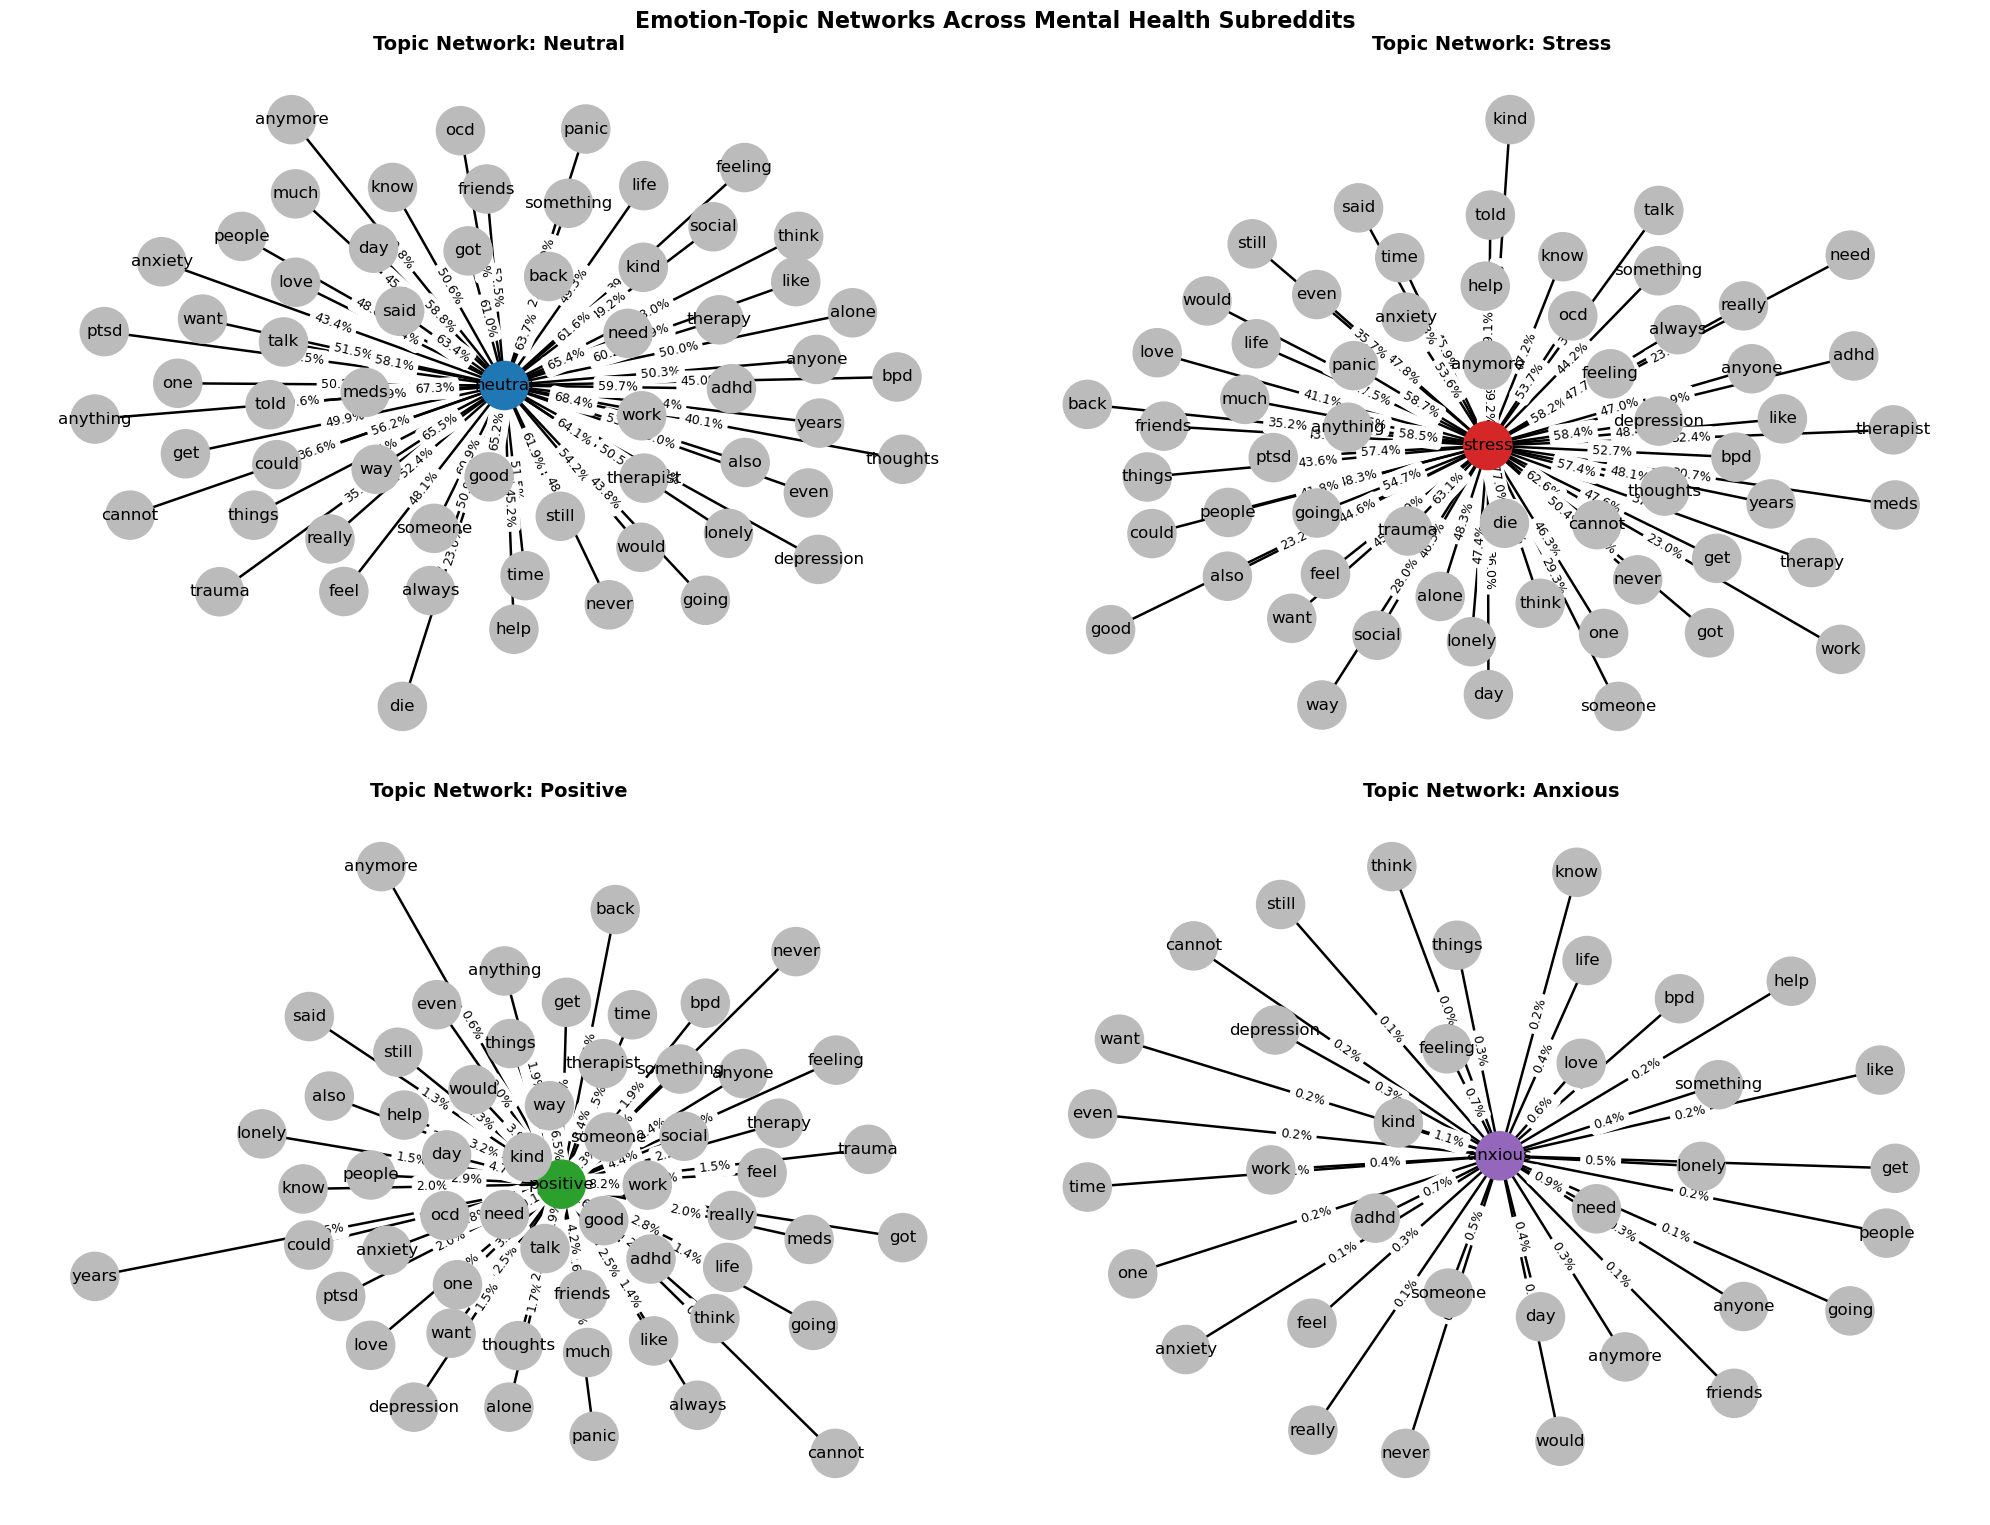

Network Summary Statistics:
Neutral: 59 topics, strength range: 23.0%-68.4%
Stress: 59 topics, strength range: 18.9%-77.0%
Positive: 57 topics, strength range: 0.5%-18.4%
Anxious: 35 topics, strength range: 0.0%-1.1%


In [4]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# -----------------------------
# 1. LOAD YOUR DATA
# -----------------------------
df = pd.read_csv("emotion_topic_links_auto.csv")   # change filename

# ensure correct types
df["emotion"] = df["emotion"].astype(str)
df["topic"] = df["topic"].astype(str)

# -----------------------------
# 2. TOTAL COUNT PER TOPIC
# -----------------------------
topic_total = df.groupby("topic")["count"].sum().reset_index()
topic_total.columns = ["topic", "topic_total"]

df = df.merge(topic_total, on="topic")

# -----------------------------
# 3. PERCENTAGE per emotion-topic
# -----------------------------
df["percentage"] = (df["count"] / df["topic_total"]) * 100

# -----------------------------
# 4. GRAPH COLORS
# -----------------------------
emotion_colors = {
    "neutral": "#1f77b4",
    "stress": "#d62728", 
    "positive": "#2ca02c",
    "anxious": "#9467bd"
}

# -----------------------------
# 5. CREATE 2x2 SUBPLOT FIGURE
# -----------------------------
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
emotions = ["neutral", "stress", "positive", "anxious"]

for idx, emotion in enumerate(emotions):
    ax = axes[idx // 2, idx % 2]  # Get the correct subplot axis
    
    subset = df[df["emotion"] == emotion]

    if subset.empty:
        ax.text(0.5, 0.5, f"No data for emotion: {emotion}", 
                ha='center', va='center', transform=ax.transAxes, fontsize=12)
        ax.set_title(f"Topic Network: {emotion.capitalize()}", fontsize=14, fontweight='bold')
        continue

    G = nx.Graph()

    # add edges from emotion → topic with percentage weight (same as your code)
    for _, row in subset.iterrows():
        G.add_edge(emotion, row["topic"], weight=row["percentage"])

    # wide spacing (same layout parameters)
    pos = nx.spring_layout(G, k=2.0, iterations=200, seed=42)  # added seed for consistency

    # node colors (same as your code)
    node_colors = []
    for node in G.nodes():
        if node == emotion:
            node_colors.append(emotion_colors[emotion])
        else:
            node_colors.append("#bbbbbb")  # topic nodes grey

    # draw graph on the specific subplot axis
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=1200, ax=ax)
    nx.draw_networkx_edges(G, pos, width=1.8, ax=ax)
    nx.draw_networkx_labels(G, pos, ax=ax)

    # edge labels (%) - same as your code
    edge_labels = nx.get_edge_attributes(G, "weight")
    edge_labels = {k: f"{v:.1f}%" for k, v in edge_labels.items()}

    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9, ax=ax)

    ax.set_title(f"Topic Network: {emotion.capitalize()}", fontsize=14, fontweight='bold')
    ax.axis("off")

# Add overall title for the entire figure
plt.suptitle("Emotion-Topic Networks Across Mental Health Subreddits", 
             fontsize=16, fontweight='bold', y=0.95)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.subplots_adjust(top=0.92)

plt.show()

# Print the same summary statistics
print("Network Summary Statistics:")
for emotion in emotions:
    emotion_data = df[df['emotion'] == emotion]
    if not emotion_data.empty:
        num_topics = len(emotion_data)
        max_percentage = emotion_data['percentage'].max()
        min_percentage = emotion_data['percentage'].min()
        print(f"{emotion.capitalize()}: {num_topics} topics, strength range: {min_percentage:.1f}%-{max_percentage:.1f}%")

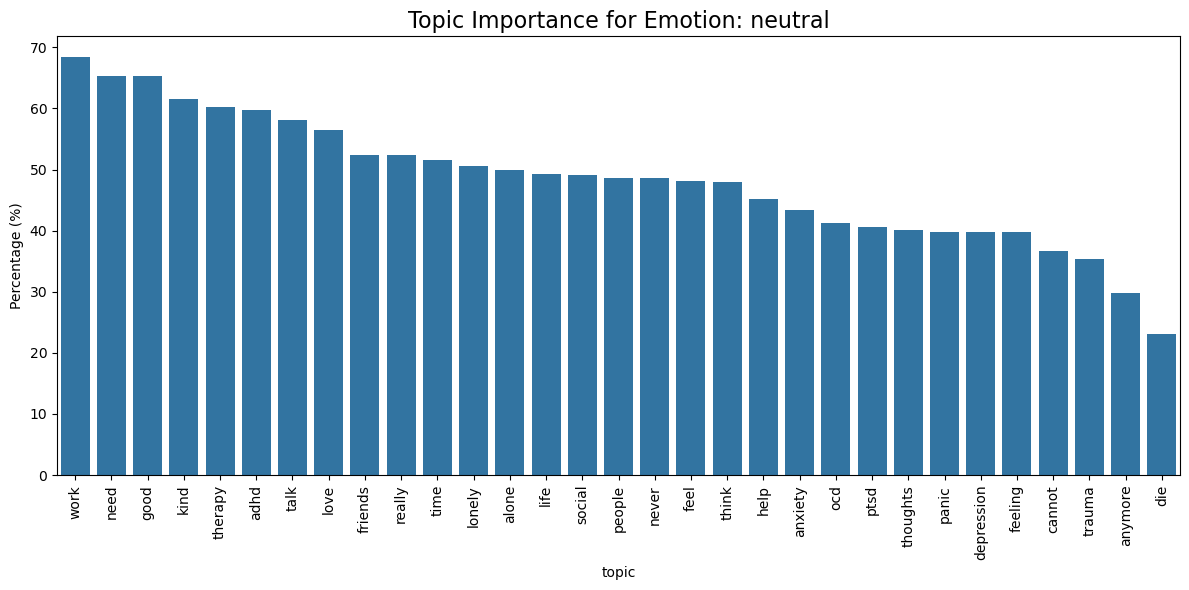

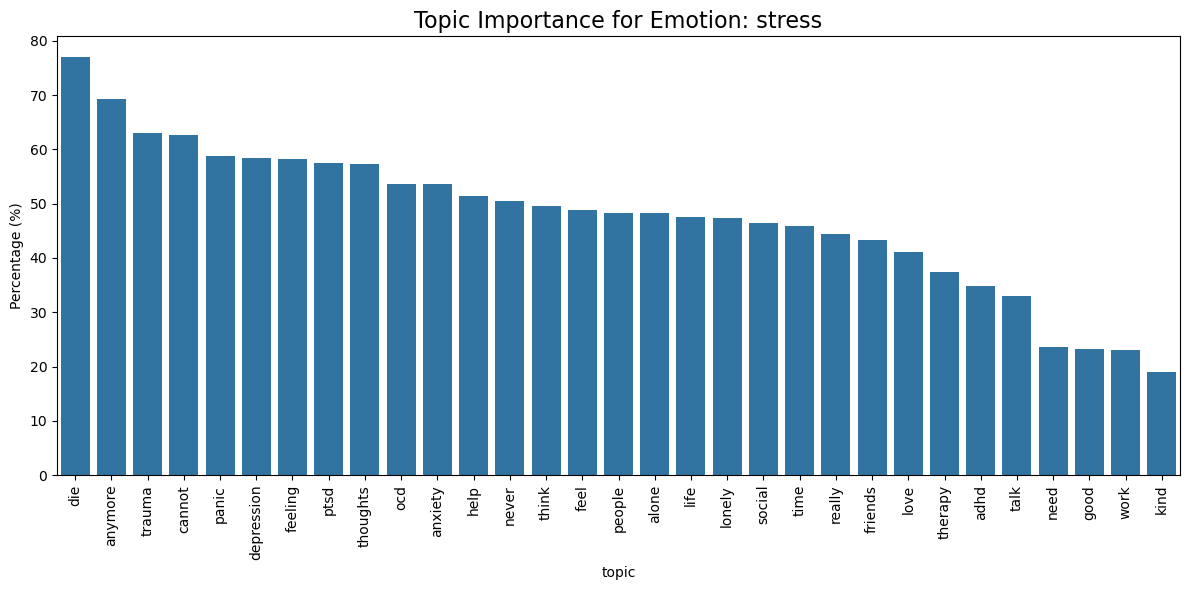

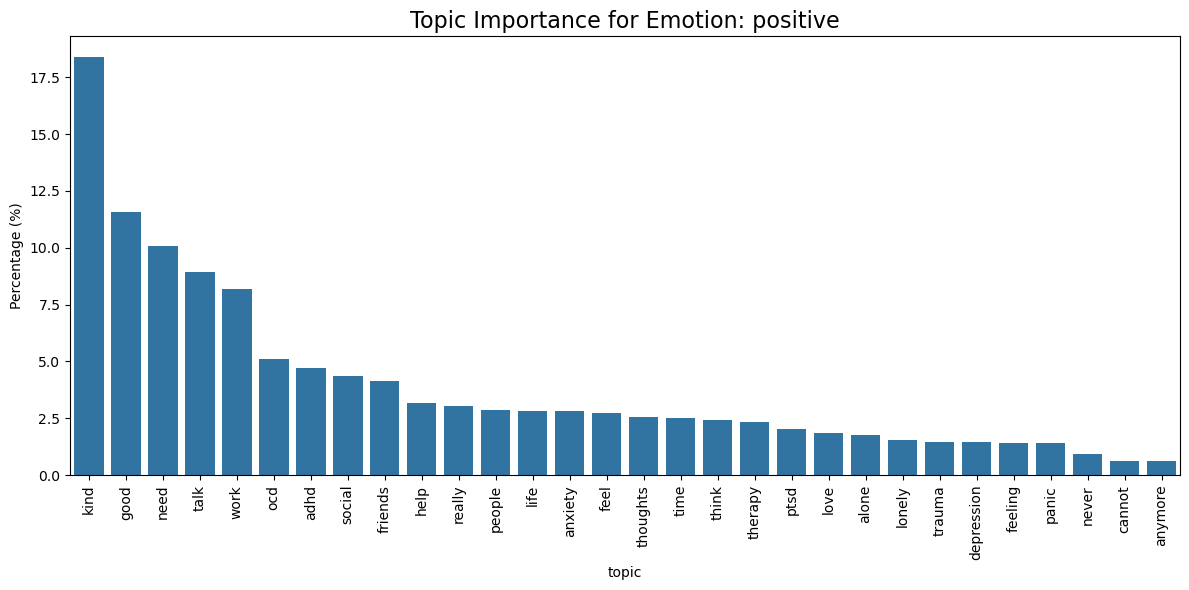

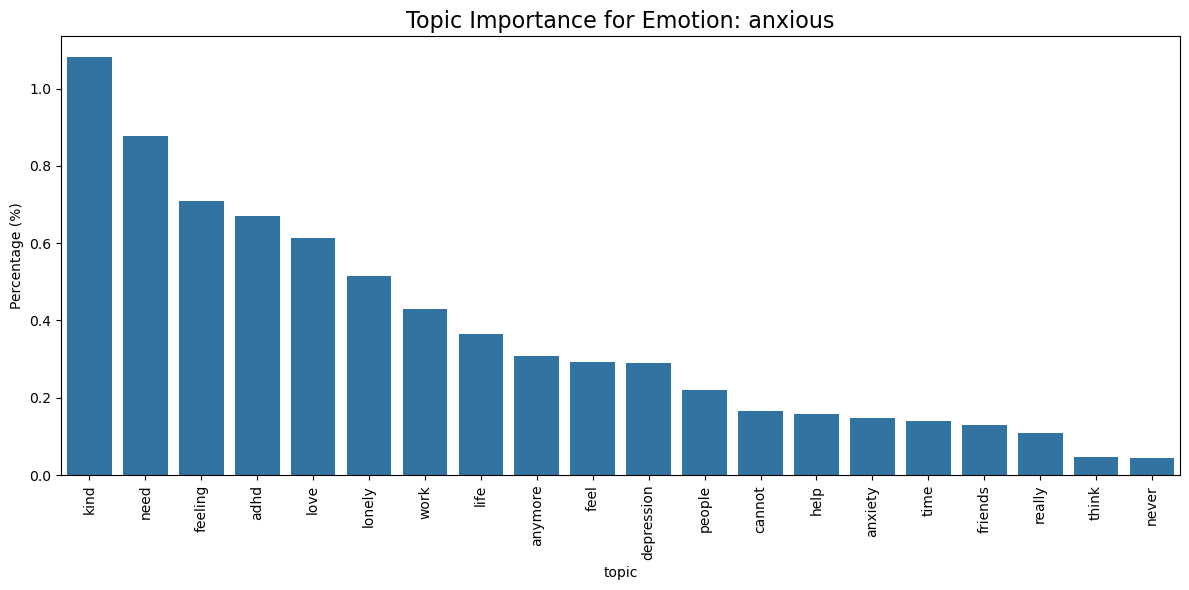

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------
# 1. Key topics list
# -------------------------
key_topics = [
    "feel","life","cannot","people","time","friends","never","anymore",
    "think","really","depression","anxiety","panic","feeling","help","die",
    "lonely","alone","talk","social","love","adhd","work","ptsd","trauma",
    "thoughts","ocd","good","need","therapy","kind"
]

# -------------------------
# 3. Filter only those key topics
# -------------------------
df = df[df["topic"].isin(key_topics)]

# -------------------------
# 4. Compute topic_total (YOU DO NOT NEED IT IN CSV)
# -------------------------
topic_total = (
    df.groupby("topic")["count"]
    .sum()
    .reset_index()
)

topic_total.columns = ["topic", "topic_total"]

# Merge back
df = df.merge(topic_total, on="topic")

# -------------------------
# 5. Calculate % for each emotion within each topic
# -------------------------
df["percentage"] = (df["count"] / df["topic_total"]) * 100

# -------------------------
# 6. Plot separate bar charts for each emotion
# -------------------------
emotions = ["neutral", "stress", "positive", "anxious"]

for emo in emotions:
    sub = df[df["emotion"] == emo].sort_values("percentage", ascending=False)

    plt.figure(figsize=(12, 6))
    sns.barplot(data=sub, x="topic", y="percentage")
    plt.title(f"Topic Importance for Emotion: {emo}", fontsize=16)
    plt.ylabel("Percentage (%)")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


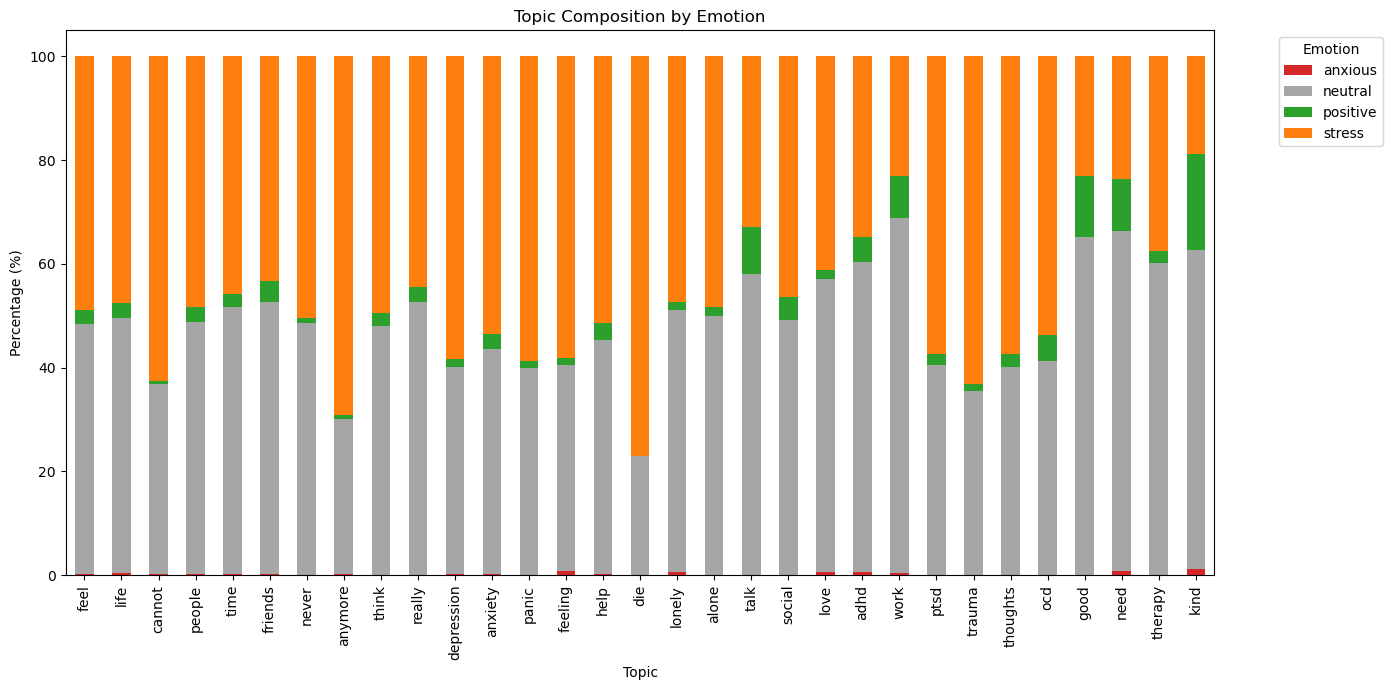

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------
# 1. Key topics list
# -------------------------
key_topics = [
    "feel","life","cannot","people","time","friends","never","anymore",
    "think","really","depression","anxiety","panic","feeling","help","die",
    "lonely","alone","talk","social","love","adhd","work","ptsd","trauma",
    "thoughts","ocd","good","need","therapy","kind"
]

# -------------------------
# 3. Filter only key topics
# -------------------------
df = df[df["topic"].isin(key_topics)]

# -------------------------
# 4. Compute topic_total
# -------------------------
# Rename the aggregated column to avoid merge conflicts
topic_total = df.groupby("topic")["count"].sum().reset_index().rename(columns={"count": "topic_total"})

# Merge back
df = df.drop(columns=["topic_total"], errors='ignore')  # drop if exists
df = df.merge(topic_total, on="topic")

# -------------------------
# 5. Calculate percentage per emotion
# -------------------------
df["percentage"] = (df["count"] / df["topic_total"]) * 100

# -------------------------
# 6. Pivot for stacked bar chart
# -------------------------
pivot_df = df.pivot(index="topic", columns="emotion", values="percentage").fillna(0)
pivot_df = pivot_df.reindex(key_topics)  # maintain original order

# -------------------------
# 7. Plot stacked bar chart
# -------------------------
# Optional: custom colors for emotions
colors = {
    "neutral": "#a6a6a6",  # gray
    "stress": "#ff7f0e",   # orange
    "positive": "#2ca02c", # green
    "anxious": "#d62728"   # red
}

pivot_df.plot(
    kind="bar",
    stacked=True,
    figsize=(14, 7),
    color=[colors.get(c, "#333333") for c in pivot_df.columns]  # fallback gray
)

plt.ylabel("Percentage (%)")
plt.xlabel("Topic")
plt.title("Topic Composition by Emotion")
plt.xticks(rotation=90)
plt.legend(title="Emotion", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


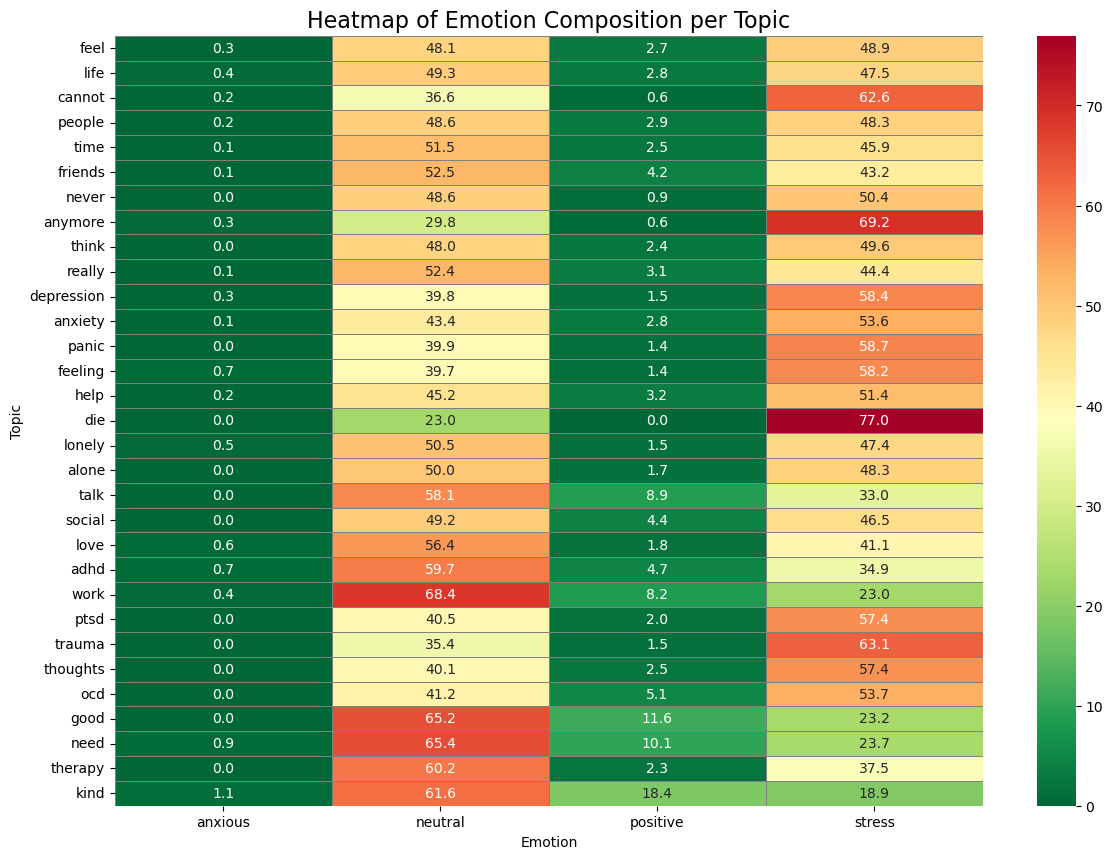

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

# -------------------------
# 1. Generate heatmap
# -------------------------
plt.figure(figsize=(14, 10))

# Using the same pivot_df with topics as rows and emotions as columns
sns.heatmap(
    pivot_df,
    annot=True,        # show the percentage values
    fmt=".1f",         # one decimal place
    cmap="RdYlGn_r",   # red to green, reversed for higher = more intense
    linewidths=0.5,
    linecolor='gray'
)

plt.title("Heatmap of Emotion Composition per Topic", fontsize=16)
plt.ylabel("Topic")
plt.xlabel("Emotion")
plt.yticks(rotation=0)  # keep topic names horizontal
plt.show()


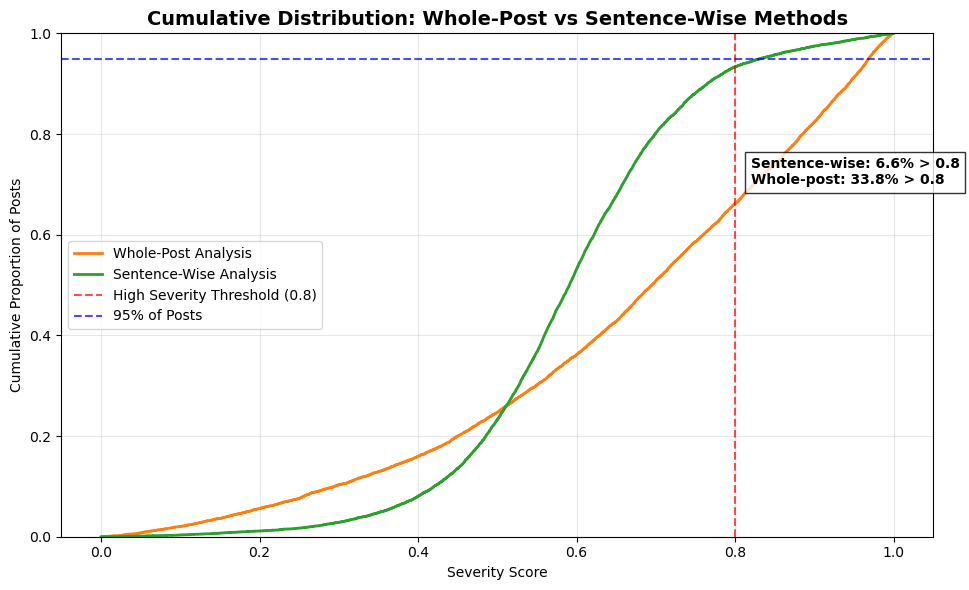

In [3]:
plt.figure(figsize=(10, 6))

# Create CDF plot
sns.ecdfplot(data=df_whole, x='severity', label='Whole-Post Analysis', color='#ff7f0e', linewidth=2)
sns.ecdfplot(data=df_sentence, x='severity', label='Sentence-Wise Analysis', color='#2ca02c', linewidth=2)

plt.title('Cumulative Distribution: Whole-Post vs Sentence-Wise Methods', fontsize=14, fontweight='bold')
plt.xlabel('Severity Score')
plt.ylabel('Cumulative Proportion of Posts')
plt.legend()
plt.grid(True, alpha=0.3)

# Highlight the high-severity region
plt.axvline(x=0.8, color='red', linestyle='--', alpha=0.7, label='High Severity Threshold (0.8)')
plt.axhline(y=0.95, color='blue', linestyle='--', alpha=0.7, label='95% of Posts')

# Add annotations for high severity differences
high_sev = 0.8
whole_prop = len(df_whole[df_whole['severity'] > high_sev]) / len(df_whole)
sentence_prop = len(df_sentence[df_sentence['severity'] > high_sev]) / len(df_sentence)

plt.text(0.82, 0.7, f'Sentence-wise: {sentence_prop:.1%} > 0.8\nWhole-post: {whole_prop:.1%} > 0.8',
         bbox=dict(facecolor='white', alpha=0.8), fontweight='bold')

plt.legend()
plt.tight_layout()
plt.show()

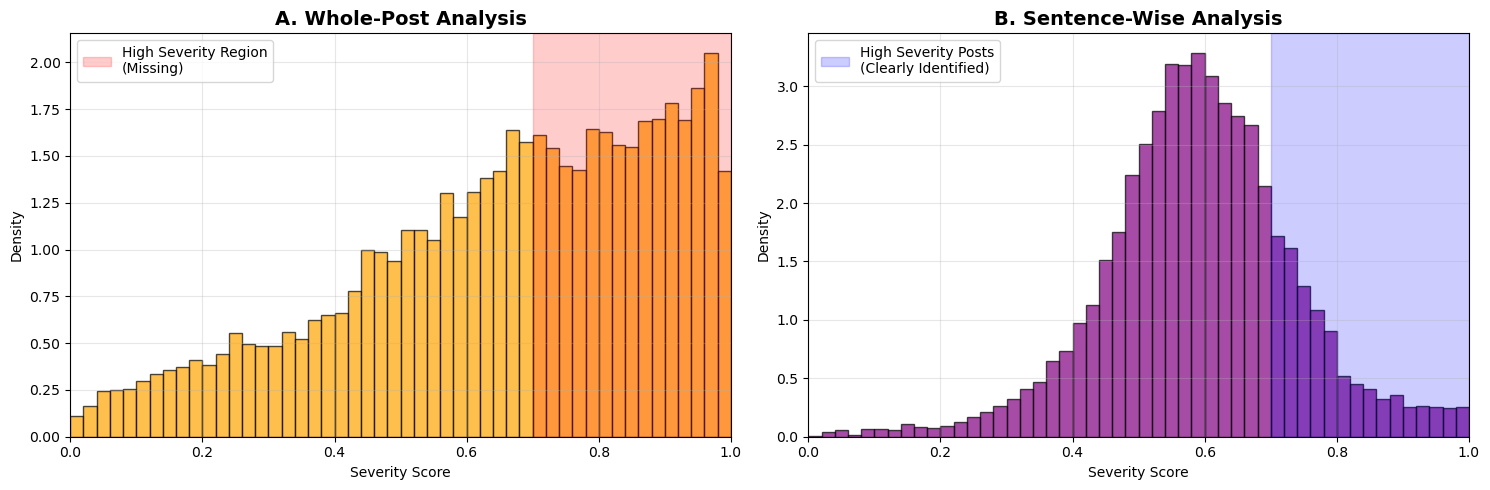

WHOLE-POST ANALYSIS STATISTICS:
Score range: 0.000 to 1.000
Standard deviation: 0.240
Top 5% severity threshold: 0.968

SENTENCE-WISE ANALYSIS STATISTICS:
Score range: 0.000 to 1.000
Standard deviation: 0.144
Top 5% severity threshold: 0.832

Posts with severity > 0.8:
Whole-post method: 3381 posts
Sentence-wise method: 664 posts
Sentence-wise method detects 0.2x more high-severity posts


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
df_whole = pd.read_csv('output/reddit_with_valence_arousal_severity.csv')  # Whole-post analysis
df_sentence = pd.read_csv('output/reddit_with_valence_arousal_severity_with_risk.csv')  # Sentence-wise analysis

# Create the comparison plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Whole-post analysis
ax1.hist(df_whole['severity'], bins=50, color='orange', alpha=0.7, edgecolor='black', density=True)
ax1.set_title('A. Whole-Post Analysis', fontsize=14, fontweight='bold')
ax1.set_xlabel('Severity Score')
ax1.set_ylabel('Density')
ax1.set_xlim(0, 1)
ax1.grid(True, alpha=0.3)

# Plot 2: Sentence-wise analysis
ax2.hist(df_sentence['severity'], bins=50, color='purple', alpha=0.7, edgecolor='black', density=True)
ax2.set_title('B. Sentence-Wise Analysis', fontsize=14, fontweight='bold')
ax2.set_xlabel('Severity Score')
ax2.set_ylabel('Density')
ax2.set_xlim(0, 1)
ax2.grid(True, alpha=0.3)

# Highlight the high-severity region where sentence-wise method excels
ax1.axvspan(0.7, 1.0, alpha=0.2, color='red', label='High Severity Region\n(Missing)')
ax1.legend()

ax2.axvspan(0.7, 1.0, alpha=0.2, color='blue', label='High Severity Posts\n(Clearly Identified)')
ax2.legend()

plt.tight_layout()
plt.show()

# Print comparative statistics
print("WHOLE-POST ANALYSIS STATISTICS:")
print(f"Score range: {df_whole['severity'].min():.3f} to {df_whole['severity'].max():.3f}")
print(f"Standard deviation: {df_whole['severity'].std():.3f}")
print(f"Top 5% severity threshold: {df_whole['severity'].quantile(0.95):.3f}")

print("\nSENTENCE-WISE ANALYSIS STATISTICS:")
print(f"Score range: {df_sentence['severity'].min():.3f} to {df_sentence['severity'].max():.3f}")
print(f"Standard deviation: {df_sentence['severity'].std():.3f}")
print(f"Top 5% severity threshold: {df_sentence['severity'].quantile(0.95):.3f}")

# Calculate how many more high-severity posts are detected
high_sev_threshold = 0.8
whole_high_count = len(df_whole[df_whole['severity'] > high_sev_threshold])
sentence_high_count = len(df_sentence[df_sentence['severity'] > high_sev_threshold])

print(f"\nPosts with severity > {high_sev_threshold}:")
print(f"Whole-post method: {whole_high_count} posts")
print(f"Sentence-wise method: {sentence_high_count} posts")
print(f"Sentence-wise method detects {sentence_high_count/whole_high_count:.1f}x more high-severity posts")

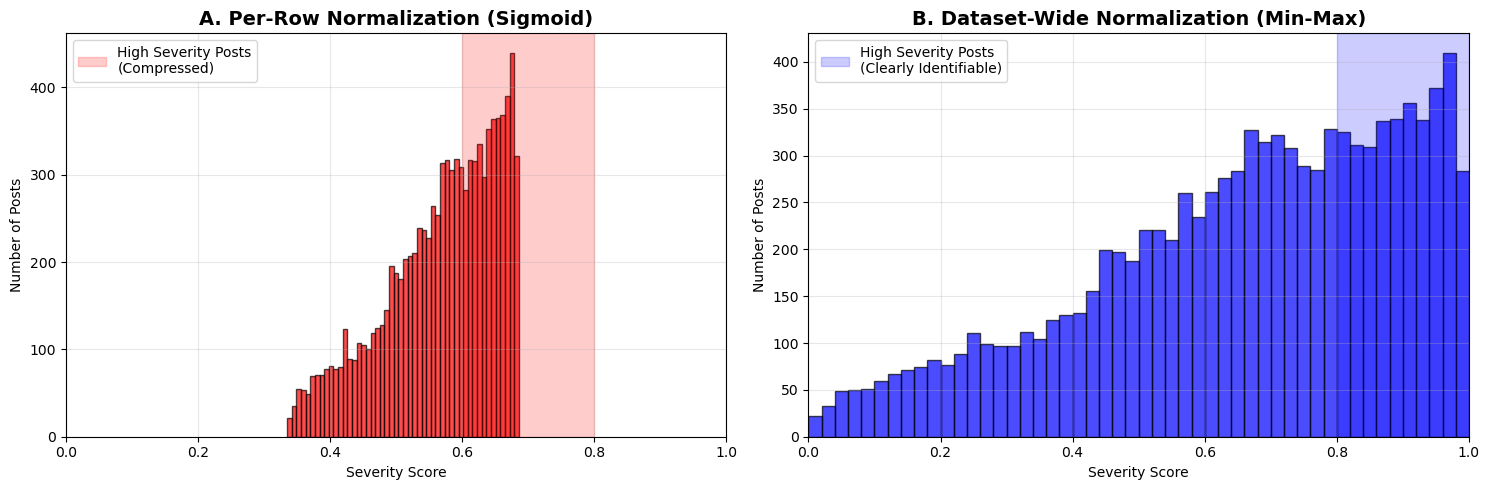

PER-ROW NORMALIZATION STATISTICS:
Score range: 0.335 to 0.686
Standard deviation: 0.085
Top 1% severity threshold: 0.683

DATASET-WIDE NORMALIZATION STATISTICS:
Score range: 0.000 to 1.000
Standard deviation: 0.240
Top 1% severity threshold: 0.992


In [1]:
import matplotlib.pyplot as plt
import pandas as pd

# Load your two datasets
df_per_row = pd.read_csv('output/reddit_with_valence_arousal_severity_per_row.csv')
df_dataset = pd.read_csv('output/reddit_with_valence_arousal_severity.csv')

# Create the comparison plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Per-row normalization
ax1.hist(df_per_row['severity'], bins=50, color='red', alpha=0.7, edgecolor='black')
ax1.set_title('A. Per-Row Normalization (Sigmoid)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Severity Score')
ax1.set_ylabel('Number of Posts')
ax1.set_xlim(0, 1)
ax1.grid(True, alpha=0.3)

# Plot 2: Dataset-wide normalization
ax2.hist(df_dataset['severity'], bins=50, color='blue', alpha=0.7, edgecolor='black')
ax2.set_title('B. Dataset-Wide Normalization (Min-Max)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Severity Score')
ax2.set_ylabel('Number of Posts')
ax2.set_xlim(0, 1)
ax2.grid(True, alpha=0.3)

# Highlight the problem area - where high severity posts get compressed
ax1.axvspan(0.6, 0.8, alpha=0.2, color='red', label='High Severity Posts\n(Compressed)')
ax1.legend()

# Highlight the same posts in the correct method
ax2.axvspan(0.8, 1.0, alpha=0.2, color='blue', label='High Severity Posts\n(Clearly Identifiable)')
ax2.legend()

plt.tight_layout()
plt.show()

# Print some statistics to reinforce the point
print("PER-ROW NORMALIZATION STATISTICS:")
print(f"Score range: {df_per_row['severity'].min():.3f} to {df_per_row['severity'].max():.3f}")
print(f"Standard deviation: {df_per_row['severity'].std():.3f}")
print(f"Top 1% severity threshold: {df_per_row['severity'].quantile(0.99):.3f}")

print("\nDATASET-WIDE NORMALIZATION STATISTICS:")
print(f"Score range: {df_dataset['severity'].min():.3f} to {df_dataset['severity'].max():.3f}")
print(f"Standard deviation: {df_dataset['severity'].std():.3f}")
print(f"Top 1% severity threshold: {df_dataset['severity'].quantile(0.99):.3f}")